In [1]:
import os
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import myServices as ms
import randForest as rfr
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_curve, auc, roc_auc_score, f1_score
import joblib

In [2]:
# to compute ececution time do:
# with timeit():
#     # your code, e.g., 
class timeit(): 
    from datetime import datetime
    def __enter__(self):
        self.tic = self.datetime.now()
    def __exit__(self, *args, **kwargs):
        print('runtime: {}'.format(self.datetime.now() - self.tic))

## Importing and manipulating datasets

In [ ]:
sklearn.metrics.get_scorer_names()

In [ ]:
# basin1CleanToTrain.csv
# original = pd.read_csv('basin1CleanToTrain.csv', index_col = None)
DS = pd.read_csv('basin1_FaccNorm.csv', index_col = None)

In [ ]:
DS.describe()

In [ ]:
X,Y = ms.importDataSet('basin1_FaccNorm.csv', 'percentage')
x_train,x_validation,y_train, y_validation = train_test_split(X,Y, test_size = 0.2) 

In [ ]:
x_validation['percentage'] = y_validation
print(x_validation.head())

In [ ]:
x_validation.to_csv('basin1Validation.csv', index = None)

In [ ]:
x_train['percentage'] = y_train
print(x_train.head())

In [ ]:
x_train.to_csv('basin1Train.csv', index = None)

In [ ]:
RFClassifier = rfr.implementRandomForestCalssifier()

In [ ]:
model = rfr.loadModel('./bestModels/21-46-40 Classifier/2207232146.pkl')

In [ ]:
print(model)

# Data description and visualization

In [ ]:
### FAcc vs Labels
targets = DS['percentage']
FAcc = original['FAcc']
FAcc_norm = DS['FAcc_norm']
fig, axs = plt.subplots(1, 2, figsize=(13,4), sharey=True)
fig.text(-0.02, 0.5, 'labels', va='center', rotation='vertical')
fig.text(0.5, 1, 'Flow accumulation vs labels distribution', ha ='center')
axs[0].scatter(FAcc,targets)
# axs[0].set_title("Facc")
axs[0].set(xlabel='a) Flow Accumulation')
axs[1].scatter(FAcc_norm,targets)
# axs[1].set_title("FAcc_norm")
axs[1].set(xlabel='b) Flow Accumulation estandardized')
plt.rcParams['font.size'] = '20'
fig.tight_layout()


In [ ]:
##3 Al features vs labels
# 'disToRiv', 'TWI', 'TPI', 'slope', 'elevation',
targets = DS['percentage']
# targets = np.where( targets == 5, 2,targets)

E = DS['elevation'] 
slope = DS['slope']
FAcc = DS['FAcc_norm']
S = DS['disToRiv']
TWI = DS['TWI']
TPI = DS['TPI']

fig, axs = plt.subplots(3, 2, figsize=(13, 8), sharey=True)
fig.supylabel('Labels')
plt.rcParams['font.size'] = '15'
plt.yticks([0,1,5])
axs[0, 0].scatter(E,targets)
axs[0, 0].set_title("Elevation")
axs[1, 0].scatter(slope,targets)
axs[1, 0].set_title("Slope")
axs[2, 0].scatter(FAcc,targets)
axs[2, 0].set_title("Flow accumulation")
axs[0, 1].scatter(S,targets)
axs[0, 1].set_title("Distance to river")
axs[1, 1].scatter(TWI,targets)
axs[1, 1].set_title("TWI")
axs[2, 1].scatter(TPI,targets)
axs[2, 1].set_title('TPI')
fig.tight_layout()


In [ ]:
print(DS.head())
#  Return a dataset with the rows corresponding to the index where condition in DS.columName is valid. 
dsArray = DS[DS.percentage != 0] print(dsArray.head())
print(dsArray.head()) 

In [ ]:
sns.set(font_scale=1.5)
sns.pairplot(DS, hue = 'percentage', diag_kind = 'kde', 
             plot_kws = {'alpha': 0.8, 's': 100},
             height = 4, corner=True, palette = "Set2")# vars = ['life_exp', 'log_pop', 'log_gdp_per_cap'],

# sns.pairplot(DS, hue="percentage")

In [2]:
####. Covariance Matrix
matrix = DS.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.show()

NameError: name 'DS' is not defined

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(criterion='entropy', random_state = 50)
x_train,y_train = ms.importDataSet('basin1Train.csv', 'percentage')
classifier = OneVsRestClassifier(estimator).fit(x_train,y_train)

In [2]:
# classifier = rfr.loadModel('./outputs/2022-08-02/11-01-47/2208021101.pkl')

x_test,y_test = ms.importDataSet('basin1Validation.csv', 'percentage')
y_prob = classifier.predict_proba(x_test)
#print(np.unique(y_prob))

UNIQUE CLASSES:  [0 1 5]
values,  counts
[[     0 485478]
 [     1   1837]
 [     5   8593]]
values,  counts
[[     0 486266]
 [     1   1539]
 [     2   8103]]
actual class: 0 vs rest [1, 5]
Class 0 balance vs rest
values,  counts
[[     0  10430]
 [     1 485478]]
actual class: 1 vs rest [0, 5]
Class 1 balance vs rest
values,  counts
[[     0 494071]
 [     1   1837]]
actual class: 5 vs rest [0, 1]
Class 5 balance vs rest
values,  counts
[[     0 487315]
 [     1   8593]]


{0: 0.5731899421012062, 1: 0.9139675941990785, 5: 0.959290557907028}

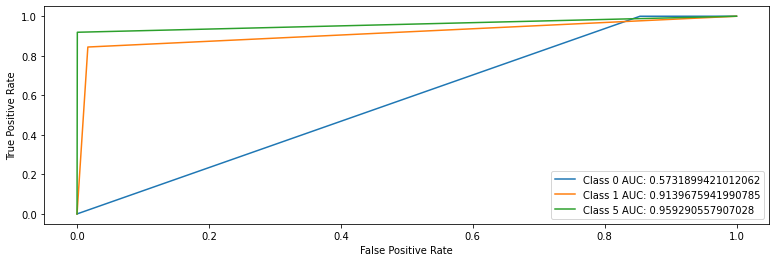

<Figure size 432x288 with 0 Axes>

In [3]:
rfr.plot_ROC_AUC_OneVsRest(classifier, x_test, y_test)